In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly
import plotly.graph_objs as go
import plotly.plotly as py
from sklearn import preprocessing, manifold, cluster

In [2]:
plotly.tools.set_credentials_file(username='navravi', api_key='uYbUJOZ3VYmK0YILm3Gq')

In [3]:
scores = pd.read_csv('compas-scores-two-years.csv',
                     usecols=['age', 'c_charge_degree', 'race', 'score_text',
                              'sex', 'priors_count', 'days_b_screening_arrest',
                              'decile_score', 'is_recid', 'two_year_recid',
                              'c_jail_in', 'c_jail_out', 'c_charge_desc'],
                     parse_dates=['c_jail_in', 'c_jail_out'])

scores = scores[scores['days_b_screening_arrest'] <= 30]
scores = scores[scores['days_b_screening_arrest'] >= -30]
scores = scores[scores['is_recid'] != -1]
scores = scores[scores['c_charge_degree'] != 'O']
scores = scores[scores['score_text'] != 'N/A']

scores.loc[:, 'c_jail_time'] = scores['c_jail_out'] - scores['c_jail_in']
                
scores.head()

,sex,age,race,decile_score,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_charge_degree,c_charge_desc,is_recid,score_text,two_year_recid,c_jail_time
0,Male,69,Other,1,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,F,Aggravated Assault w/Firearm,0,Low,0,0 days 23:37:38
1,Male,34,African-American,3,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,F,Felony Battery w/Prior Convict,1,Low,1,10 days 01:51:26
2,Male,24,African-American,4,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,F,Possession of Cocaine,1,Low,1,1 days 02:03:30
5,Male,44,Other,1,0,0.0,2013-11-30 04:50:18,2013-12-01 12:28:56,M,Battery,0,Low,0,1 days 07:38:38
6,Male,41,Caucasian,6,14,-1.0,2014-02-18 05:08:24,2014-02-24 12:18:30,F,Possession Burglary Tools,1,Medium,1,6 days 07:10:06


In [4]:
#times_recid = scores[scores['c_jail_time'].notnull() & scores['is_recid']]['c_jail_time']
#times_norecid = scores[scores['c_jail_time'].notnull() & 1 - scores['is_recid']]['c_jail_time']

#scores['c_jail_time'].min(), scores['c_jail_time'].max()

In [5]:
scores_dummies = scores[['sex', 'age', 'race', 'priors_count', 'c_jail_time',
                         'c_charge_degree', 'two_year_recid']]
scores_dummies = scores_dummies.copy()

scores_dummies['c_jail_time'] = scores_dummies['c_jail_time'].dt.total_seconds()

scores_dummies['sex'].replace('Female', 0, inplace=True)
scores_dummies['sex'].replace('Male', 1, inplace=True)

scores_dummies['c_charge_degree'].replace('F', 0, inplace=True)
scores_dummies['c_charge_degree'].replace('M', 1, inplace=True)

race_dummies = pd.get_dummies(scores['race'])
scores_dummies.drop(columns='race', inplace=True)
scores_dummies = pd.concat([scores_dummies, race_dummies], axis=1)

scores_dummies.head()

,sex,age,priors_count,c_jail_time,c_charge_degree,two_year_recid,African-American,Asian,Caucasian,Hispanic,Native American,Other
0,1,69,0,85058.0,0,0,0,0,0,0,0,1
1,1,34,0,870686.0,0,1,1,0,0,0,0,0
2,1,24,4,93810.0,0,1,1,0,0,0,0,0
5,1,44,0,113918.0,1,0,0,0,0,0,0,1
6,1,41,14,544206.0,0,1,0,0,1,0,0,0


In [6]:
X = preprocessing.scale(scores_dummies)
X.shape

(6172, 12)

In [7]:
tsne = manifold.TSNE()
X_tsne = tsne.fit_transform(X)

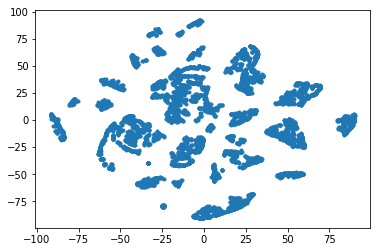

In [8]:
plt.plot(X_tsne[:, 0], X_tsne[:, 1], '.')
plt.show()

In [9]:
kmeans = cluster.KMeans(2)
clusters = kmeans.fit_predict(X)

In [10]:
def make_label(row):
    #return ', '.join('{}: {}'.format(k, v) for k, v in row.items())
    return 'score: {}, crime: {}'.format(row['decile_score'], row['c_charge_desc'])

In [11]:
trace = go.Scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], mode='markers',
                   text=scores.apply(make_label, axis=1),
                   marker={'color': clusters, 'colorscale': 'Picnic'})
fig = {'data': [trace], 'layout': {'title': 'TSNE Visualization of Clusters'}}
py.iplot(fig, filename='tsne-clusters')

In [12]:
trace = go.Scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], mode='markers',
                   text=scores.apply(make_label, axis=1),
                   marker={'color': scores['decile_score'], 'colorscale': 'Viridis'})
fig = {'data': [trace], 'layout': {'title': 'TSNE Visualization of COMPAS Scores'}}
py.iplot(fig, filename='tsne-scores')